In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [40]:
def parse(filename : str) -> pd.DataFrame:
    data = {
            "t": [],
            "x": [],
            "y": [],
            "z": [],
            "u(p)": [],
            "0.0": [],
            "0.00": [],
            "fN-used": []
        }

    headerLen = 9
    with open(filename) as file:
        for i, line in enumerate(file):
            if i >= headerLen:         
                part = line.split()
                data["t"].append(float(part[0]))
                data["y"].append(float(part[1]))
                data["z"].append(float(part[2]))
                data["x"].append(float(part[3]))
                data["u(p)"].append(float(part[4]))
                data["0.0"].append(float(part[5]))
                data["0.00"].append(float(part[6]))
                data["fN-used"].append(float(part[7]))

    for d in data:
        data[d] = np.array(data[d])
            
    return pd.DataFrame(data)

In [41]:
def get_velocities(df : pd.DataFrame) -> pd.DataFrame:
    vel = {
        "Vx": [],
        "Vy": [],
        "Vz": [],
        "Px": [],
        "Py": [],
        "Pz": []
    }

    # note time is the 0th coordinate
    # x,y,z are 1,2,3
    for coord in (1,2,3):
        for i in range(5, len(df)-5):
            T1 = (df.iloc[i+5,coord] - df.iloc[i,coord])/(df.iloc[i+5,0]-df.iloc[i,0])
            T2 = (df.iloc[i+4,coord] - df.iloc[i-1,coord])/(df.iloc[i+4,0]-df.iloc[i-1,0])
            T3 = (df.iloc[i+3,coord] - df.iloc[i-2,coord])/(df.iloc[i+3,0]-df.iloc[i-2,0])
            T4 = (df.iloc[i+2,coord] - df.iloc[i-3,coord])/(df.iloc[i+2,0]-df.iloc[i-3,0])
            T5 = (df.iloc[i+1,coord] - df.iloc[i-4,coord])/(df.iloc[i+1,0]-df.iloc[i-4,0])
            T6 = (df.iloc[i,coord] - df.iloc[i-5,coord])/(df.iloc[i,0]-df.iloc[i-5,0])
            v = 0.1*T1+0.15*T2+0.25*T3+0.25*T4+0.15*T5+0.1*T6
            # add v to vel dataframe
            if (coord == 1):
                vel["Vx"].append(float(v))
                vel["Px"].append(df.iloc[i, coord])
            elif (coord == 2):
                vel["Vy"].append(float(v))
                vel["Py"].append(df.iloc[i, coord])
            else:  
                vel["Vz"].append(float(v))
                vel["Pz"].append(df.iloc[i, coord])


    for d in vel:
        vel[d] = np.array(vel[d])
            
    return pd.DataFrame(vel)

In [42]:
def plot_traj(df : pd.DataFrame, begin : int, end : int):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    bt = int(len(df) * begin/1200)
    et = int(len(df) * end/1200)

    ax.scatter(
        df["x"].iloc[bt:et],
        df["y"].iloc[bt:et],
        -df["z"].iloc[bt:et],
        marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xbound(lower=-60, upper=60)
    ax.set_ybound(lower=-60, upper=60)
    ax.set_zbound(lower=0, upper=100)
    plt.show()

In [50]:
def vel_cylin(vdf: pd.DataFrame) -> pd.DataFrame:
    velc = {
        "Vr" : [],
        "Vtheta" : [],
        "Vz" : [],
        "Pr" : [],
        "Ptheta" : [],
        "Pz" : [],
    }
    
    for i in range(len(vdf)):
        velc["Vr"].append(np.sqrt(vdf.iloc[i, 0]**2 + vdf.iloc[i, 1]**2))
        velc["Vtheta"].append(np.arctan2(vdf.iloc[i,1], vdf.iloc[i,0]) + np.pi)
        velc["Vz"].append(vdf.iloc[i,2])
        velc["Pr"].append(np.sqrt(vdf.iloc[i, 3]**2 + vdf.iloc[i, 4]**2))
        velc["Ptheta"].append(np.arctan2(vdf.iloc[i,4], vdf.iloc[i,3]) + np.pi)
        velc["Pz"].append(vdf.iloc[i,5])


    for d in velc:
        velc[d] = np.array(velc[d])
    
    return pd.DataFrame(velc)

In [62]:
def plot_vel_stream(vcylin: pd.DataFrame, begin: int, end: int, rows: int, cols: int):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    bt = int(len(vcylin) * begin/1200)
    et = int(len(vcylin) * end/1200)

    grid = []
    
    for i in range(rows):
        grid.append([])
        for j in range(cols):
            grid[i].append([])

    vgridx, vgridy = np.meshgrid(np.linspace(0, 2*np.pi, cols), np.linspace(0, 90, rows))

    #sort into grid
    for i in range(bt, et):
        #z theta
        coordx = int(np.floor(rows*vcylin.iloc[i,5]/90))
        coordy = int(np.floor(cols*((vcylin.iloc[i,4])%(2*np.pi))/(2*np.pi)))
        grid[coordx][coordy].append([vcylin.iloc[i,0], vcylin.iloc[i,1], vcylin.iloc[i,2]])
    

    for y in range(rows):
        for x in range(cols):
            if len(grid[y][x]) == 0:
                vgridx[y][x] = 0
                vgridy[y][x] = 0
            else:
                vgridx[y][x] = (sum([n[1] for n in grid[y][x]])/len(grid[y][x]))
                vgridy[y][x] = 200*(sum([n[2] for n in grid[y][x]])/len(grid[y][x]))

    X, Y = np.meshgrid(np.linspace(0, 2*np.pi, cols), np.linspace(0, 90, rows))
    ax.streamplot(
        X,
        Y,
        vgridx,
        vgridy,
        density=2.0
        )
    
    plt.xlabel("angular direction [radians]")
    plt.ylabel("height []")
    plt.title("stream line")
    ax.set_xbound(lower=0, upper=2*np.pi)
    ax.set_ybound(lower=0, upper=90)


In [52]:
m012 = parse("data/m0_12V.a")
# plot_traj(m012, 665, 790)
vdf = get_velocities(m012)
cylin = vel_cylin(vdf)
cylin

,Vr,Vtheta,Vz,Pr,Ptheta,Pz
0,0.269168,2.960577,-0.010015,38.962161,4.655894,-83.4
1,0.274557,2.888715,-0.010834,38.629005,4.603447,-83.5
2,0.279656,2.826149,-0.011084,38.222768,4.546810,-83.9
3,0.283177,2.768306,-0.009631,37.854986,4.499451,-83.8
4,0.283767,2.722223,-0.007537,37.652224,4.443575,-83.9
...,...,...,...,...,...,...
147597,0.261131,4.650617,0.000166,43.741285,6.239734,-83.6
147598,0.256157,4.570436,0.001260,43.863424,6.173535,-83.3
147599,0.273365,4.509309,-0.000163,43.795890,6.118037,-83.6
147600,0.298038,4.453932,-0.003978,43.637828,6.054325,-83.0


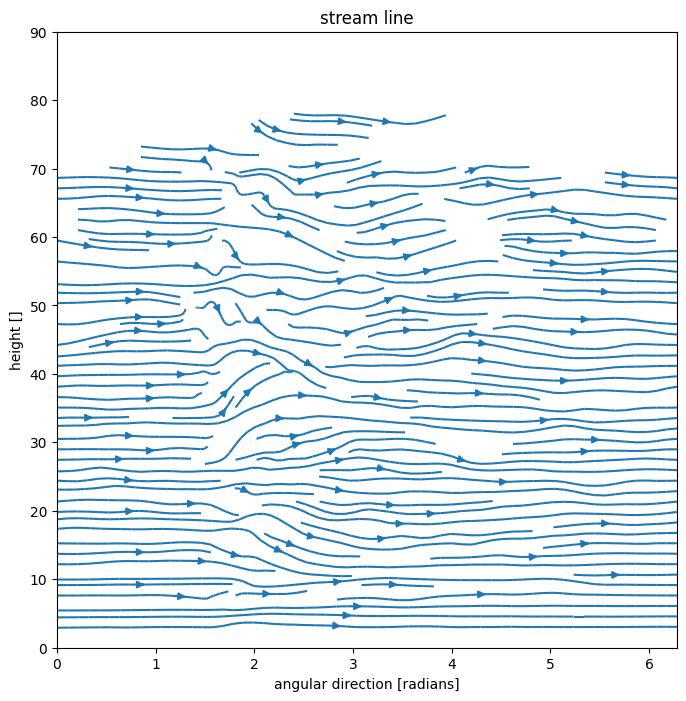

In [64]:
plot_vel_stream(cylin, 665, 790, 50, 50)

In [37]:
def vec_diff(traj, i, j) -> list[int]:
    return np.subtract(
        [float(traj[i][1]), float(traj[i][2]), float(traj[i][3])],
        [float(traj[j][1]), float(traj[j][2]), float(traj[j][3])]
        )

In [38]:
def cart2cylin(traj : list) -> list[float]:
    cylin = []
    for i in traj:
        cylin.append([np.sqrt(i[1]**2 + i[3]**2), np.arctan2(i[3],i[1]), -i[2]])
    return cylin

def cylinvelocity(vel : list) -> list[float]:
    cylin = []
    for i in vel:
        cylin.append([np.sqrt(i[0]**2 + i[2]**2), np.arctan2(i[2],i[0]), -i[1]])
    return cylin

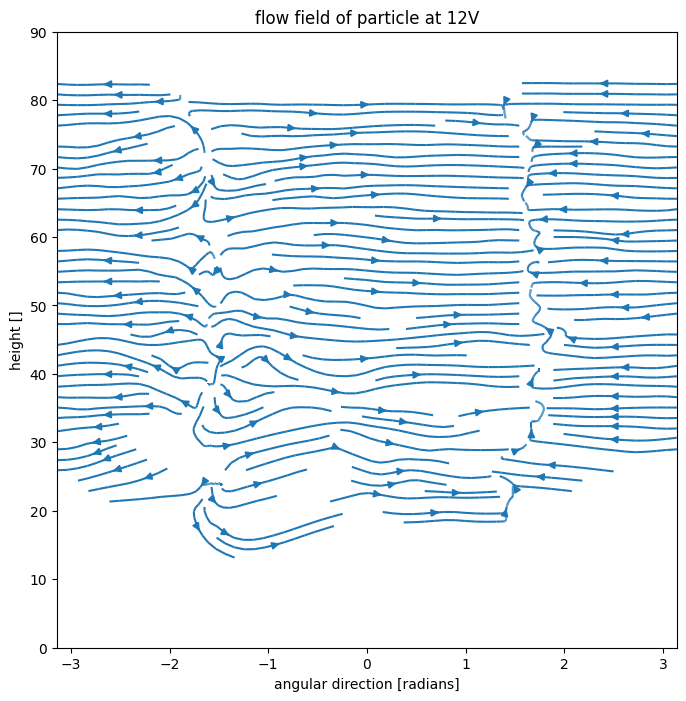

In [39]:
def plot_velocity(filename : str, title : str, begin : int, end : int):
    trajectory = []

    with open("data/" + filename + ".a") as file:
        for l, line, in enumerate(file):
            if l >= 10 + (begin * 100) and l <= (end * 100):
                trajectory.append([float(x) for x in line.split()[:4]])
    
    # find velocities
    velocities = []
    for i in range(5, len(trajectory) - 5):
        T1 = 0.10*((vec_diff(trajectory, i + 5, i))/(trajectory[i + 5][0] - trajectory[i][0]))
        T2 = 0.15*((vec_diff(trajectory, i + 4, i-1))/(trajectory[i + 4][0] - trajectory[i-1][0]))
        T3 = 0.25*((vec_diff(trajectory, i + 3, i-2))/(trajectory[i + 3][0] - trajectory[i-2][0]))
        T4 = 0.25*((vec_diff(trajectory, i + 2, i-3))/(trajectory[i + 2][0] - trajectory[i-3][0]))
        T5 = 0.15*((vec_diff(trajectory, i + 1, i-4))/(trajectory[i + 1][0] - trajectory[i-4][0]))
        T6 = 0.10*((vec_diff(trajectory, i + 0, i-5))/(trajectory[i + 0][0] - trajectory[i-5][0]))
        velocities.append(T1 + T2 + T3 + T4 + T5 + T6)
    
    fig=plt.figure(figsize=(8, 8))
    ax=fig.add_subplot()

    tcylin = cart2cylin(trajectory[5:len(trajectory) - 5])
    vcylin = cylinvelocity(velocities)

    numx = 50
    numy = 50

    grid = []
    
    for i in range(numy):
        grid.append([])
        for j in range(numx):
            grid[i].append([])

    vgridx, vgridy = np.meshgrid(np.linspace(-np.pi, np.pi, numx), np.linspace(0, 90, numy))

    #sort into grid
    for i in range(len(vcylin)):
        #z theta
        grid[int(np.floor(numy*tcylin[i][2]/90))][int(np.floor(numx*((tcylin[i][1] + np.pi)%(2*np.pi))/(2*np.pi)))].append(vcylin[i])

    # take average of grid
    for y in range(numy):
        for x in range(numx):
            if len(grid[y][x]) == 0:
                vgridx[y][x] = 0
                vgridy[y][x] = 0
            else:
                vgridx[y][x] = (sum([n[1] for n in grid[y][x]])/len(grid[y][x]))
                vgridy[y][x] = 100*(sum([n[2] for n in grid[y][x]])/len(grid[y][x]))

    X, Y = np.meshgrid(np.linspace(-np.pi, np.pi, numx), np.linspace(0, 90, numy))
    ax.streamplot(
        X,
        Y,
        vgridx,
        vgridy,
        density=2.0
        )
    
    plt.xlabel("angular direction [radians]")
    plt.ylabel("height []")
    plt.title(title)
    ax.set_xbound(lower=-np.pi, upper=np.pi)
    ax.set_ybound(lower=0, upper=90)

plot_velocity("m0_12V", "flow field of particle at 12V",665,  790)


In [ ]:
def plot_height(filename : str, title : str, begin : int, end : int):
    trajectory = []

    with open("data/" + filename + ".a") as file:
        for l, line, in enumerate(file):
            if l >= 10:
                trajectory.append(line.split()[:4])
    
    fig=plt.figure(figsize=(8, 8))
    ax=fig.add_subplot()

    ax.plot([((float(x[0])*0.001)) for x in trajectory[begin * 1000 :end * 1000]],
            [-float(x[2]) for x in trajectory][begin * 1000:end * 1000])
    plt.xlabel("Time [s]")
    plt.ylabel("Height of particle [mm]")
    plt.title("turbulent section")

In [ ]:

def plot_trajectory(filename : str, title : str, begin : int, end : int):
    
    trajectory = []

    with open("data/" + filename + ".a") as file:
        for l, line, in enumerate(file):
            if l >= 10:
                trajectory.append(line.split()[:4])
    
    fig=plt.figure(figsize=(8, 8))
    ax=fig.add_subplot(projection='3d')
    
    ax.scatter(
        [ float(x[1]) for x in trajectory][begin * 1000:end * 1000],
        [ float(x[3]) for x in trajectory][begin * 1000:end * 1000],
        [-float(x[2]) for x in trajectory][begin * 1000:end * 1000],
        c=[((float(x[0])*0.001)/(end - begin)) for x in trajectory[begin * 1000 :end * 1000]],
        marker='.')
    
    plt.xlabel("xaxis")
    plt.ylabel("yaxis")
    plt.title(title)
    ax.set_zlabel("zaxis")
    ax.set_zbound(lower=0, upper=110)
    ax.set_xbound(lower=-60, upper=60)
    ax.set_ybound(lower=-60, upper=60)
    plt.show()


In [ ]:
plot_trajectory("m0_12V", "Trajectory of particle at 12V",30,  35)

In [ ]:
plot_height("m0_12V", "Trajectory of particle at 12V",0, 1200)